### Validating analytic workflows

In this notebook we will show how to use simulations and create synthetic data to validate an analysis workflow.



In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.metrics import balanced_accuracy_score, r2_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from nilearn.maskers import NiftiMasker
from nilearn.image import smooth_img, index_img
from nilearn.datasets import (
    fetch_atlas_difumo,
    load_mni152_brain_mask,
    load_mni152_template
)
import nilearn.plotting


### Generating synthetic neuroimaging data

It can be useful to benchmark analyses using synthetic data before ever applying them to real data.  In the best case, one would actually pre-register the analyses developed on synthetic data prior applying them to real data.

Let's say that we wanted to test a new "biomarker" for brain age using task fMRI.  We could start by generating some random data (using the MNI305 mask as our starting point) and then apply our new technique to that, either using a completely random value for age, or creating age to have a specific relationship to the synthetic brain data.

First, we can set up a NiftiMasker based on the MNI305 mask:

In [2]:
mnimask = load_mni152_brain_mask(resolution=3.)
mnitemplate = load_mni152_template(resolution=3.)

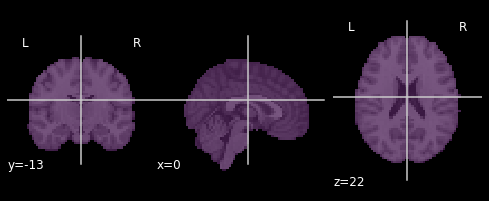

In [3]:
display = nilearn.plotting.plot_anat(mnitemplate)
display.add_overlay(mnimask, alpha=0.5)

In [4]:
masker = NiftiMasker()
maskdata = masker.fit_transform(mnimask)
maskdata.shape


(1, 69765)

We then generate random Gaussian data for each subject (let's say 100 subjects).


In [5]:
rng = np.random.default_rng(12345)
nsubs = 100
syndata = rng.normal(size=(nsubs, maskdata.shape[1]))

In [6]:
synimg = smooth_img(masker.inverse_transform(syndata), 8)
synimg.shape

(67, 79, 64, 100)

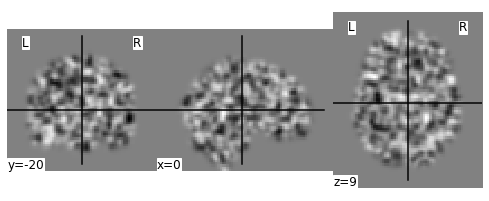

In [7]:
nilearn.plotting.plot_img(index_img(synimg, 1), cmap='gray')

### Testing our biomarker

Now let's test our biomarker.  Our innovation is to implement a feature selection procedure called Recursive Feature Elimination (RFE) to reduce the dimensionality of the data for the prediction model.  

In [8]:

def train_brainage_model(img, y, mask, nfeatures=50, n_splits=20, 
                         seed=None, shuffle_y=False, fsel='outside'):
    assert fsel is None or fsel in ('inside', 'outside')
    assert y.shape[0] == img.shape[-1]
    masker = NiftiMasker(mask)
    maskdata = masker.fit_transform(img)
    
    rng = np.random.RandomState(seed)
    if shuffle_y:
        y = y.copy()
        np.random.shuffle(y)

    estimator = LinearSVR()
    if fsel == 'outside':
        #  perform recursive feature elimination outside of CV
        selector = SelectKBest(f_regression, k=nfeatures)
        X = selector.fit_transform(maskdata, y)
    else:
        X = maskdata

    scores = []

    clf = LinearSVR()

    for i in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rng)
        if fsel == 'inside':
            # perform RFE inside CV loop
            selector = SelectKBest(f_regression, k=nfeatures)
            X_train = selector.fit_transform(X_train, y_train)
            X_test = selector.transform(X_test)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(r2_score(y_test, y_pred))
    return np.mean(scores)
    

age = rng.normal(loc=40, scale=10, size=nsubs)

train_brainage_model(synimg, age, mnimask)


0.16491122562558191

If we didn't know that there was no true relationship between the brain data and age, we wouldn't realize that this was weird.  We would likely want to know whether the observed $R^2$ is sufficiently larger than what one would expect under the null hypothesis of no predictive relationship (i.e. $R^2 = 0$).  To determine this, we can run the model repeatedly while shuffling the order of the y variable, which essentially breaks the relationship on average between the X and y variables.  In principle this should have a mean of zero (or less, given that crossvalidation using regression with smallish samples can often lead to negative $R^2$ values when the model fits the data worse than the mean; see [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7250718/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7250718/) for more).

0.2418098824425899


(array([ 1.,  1.,  2.,  6.,  7.,  4., 13.,  8.,  4.,  4.]),
 array([0.01610714, 0.05393462, 0.09176209, 0.12958957, 0.16741705,
        0.20524452, 0.243072  , 0.28089948, 0.31872696, 0.35655443,
        0.39438191]),
 <BarContainer object of 10 artists>)

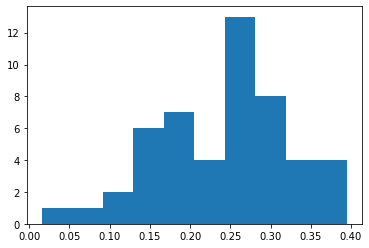

In [9]:
scores = []
nsimruns = 50
for i in range(nsimruns):
    scores.append(train_brainage_model(synimg, age, mnimask, shuffle_y=True))
print(np.mean(scores))
plt.hist(scores)

Wait, what?  The $R^2$ scores are all well above zero even when we shuffle the data, which means that there must be some kind of leaking of information from the test data into the training. In this case, it's due to the fact that our feature selection procedure was applied on the entire dataset prior to crossvalidation, rather than within the crossvalidation folks. If we move the feature selection step inside the crossvalidation loop, we should see that the predictive accuracy decreases.

In [10]:
train_brainage_model(synimg, age, mnimask, fsel='inside')


-0.36490944354990834

This example shows how injecting synthetic data into our analysis procedures can help ensure that they are not providing us with biased results.

### Generating realistic signals for testing

In the previous example we tested whether our procedure effectively controls for false positive results.  In other cases, we may also want to know the degree to which our analysis procedure can accurately detect signals when they exist (often known as "parameter recovery").  To assess this, we need to generate synthetic data that contains both realistic signal and realistic noise, and then apply our procedure to assess its effectiveness.

